# Coupled Two-Level System

Here we will look at a coupled two-level system, mainly for the purposes of learning how to use the `qutip` package. This example is based largely on some sample code shared with us by a colleague, Andrei Tretiakov. We will compare the evolution of states in a coupled two-level system with and without the rotating-wave approximation, as a potentially instructive way to examine this package's features.

In [1]:
#----- Import Libraries -----
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

## Two-Level System in Lab Frame

We start by considering a two-level system driven by an external electric field, typically from a laser though this doesn't have to be the case. The Hamiltonian can be written as,

$$ \hat{\mathcal{H}} = \frac{\hbar\omega_{0}}{2}\hat{\sigma}_{z} + \hbar\Omega\cos(\omega t + \phi)\hat{\sigma}_{x}, $$

with $\omega_{0}$ the bare level splitting, $\Omega$ the Rabi frequency representing the strength of interaction, and $\omega$ & $\phi$ the driving field's frequency and phase repsectively. The amplitude of the driving field is wrapped up in $\Omega$, so for different types of couplings this is where the information of the mechanism behind that coupling is. Any two-level Hamiltonian can be expressed through a sum of the pauli matrices (and identity) so this effectively captures most potential coupling schemes.

We will define our system by the above parameters, but we will also need to define the states or operators we will use to project the results onto. Conventionally, it is assumed we will work in the basis of $\hat{\sigma}_{z}$ (as given by the atomic term in our Hamiltonian), so our bare spin states are eigenstates of this operator. A given state is thus expressed as,

$$|\psi\rangle = c_{1}|\uparrow\rangle + c_{2}e^{i\alpha}|\downarrow\rangle, $$

with $\alpha$ representing the phase difference between the two basis states, and $|c_{i}|^2$ representing the population in the $i^{\mathrm{th}}$ spin. We will use 1 & 2 interchangeably with $\uparrow$ & $\downarrow$ respectively. The projection operators for these states are easily computed in `qutip` using the `proj()` method for a given ket/bra. This is equivalent to $|\psi\rangle\langle\psi|$ for a given state $|\psi\rangle$ to project onto. The expectation value of this operator would thus yield the corresponding population in that state.

While the populations are typically our main observable in practice, the phase is also important. For this reason we will also project onto the basis states of $\hat{\sigma}_{x}$ & $\hat{\sigma}_{y}$ as well, which are given by,

$$ |+\rangle = \frac{1}{\sqrt{2}} \left( |\uparrow\rangle + |\downarrow\rangle \right), $$
$$ |-\rangle = \frac{1}{\sqrt{2}} \left( |\uparrow\rangle - |\downarrow\rangle \right), $$
$$ |R\rangle = \frac{1}{\sqrt{2}} \left( |\uparrow\rangle + i|\downarrow\rangle \right), $$
$$ |L\rangle = \frac{1}{\sqrt{2}} \left( |\uparrow\rangle - i|\downarrow\rangle \right). $$

We will find that the phase of the driving field, $\phi$, will determine the coefficients in these bases. The phase of the state, $\alpha$, could be determined by measuring in all 3 bases (state tomography) but we won't bother with the detail of reconstructing the state from those here. 

Note that we define all the projectors together below for clarity, though we will not plot the results in the $x$ or $y$ bases for the full Hamiltonian; this is because the extra phase accumulation at frequency $\omega$ results in noisy/oscillatory plots. This is to be expected since we're not working in a rotating frame, but one should keep it in mind when performing experiments becuase, quite likely, when working in the lab your measurments are actually in the lab frame (surprising, right?).

In [2]:
#----- Global Settings -----
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz() #Shorthand pauli matrices

#--- Input Parameters ---
omega0 = 2*np.pi * 10 #Bare level splitting
Omega = 2*np.pi * 0.1 #Rabi frequency
omega = 2*np.pi * 10 #Driving frequency
phi = np.pi/4 #Driving field phase

periods = 2 #Number of periods of Omega to simulate over
t = np.linspace(0, periods*(2*np.pi/Omega), num=500) #Time axis

#--- Initial States ---
psi1, psi2 = qt.basis(2, 0), qt.basis(2, 1) #Two-level basis states
psi0 = psi1 #Initial state
psi0 = psi0.unit() #Force normalization

#--- Projection Operators ---
p1, p2 = psi1.proj(), psi2.proj() #Project onto bare spins (z-basis)
psip, psim = (psi1 + psi2).unit(), (psi1 - psi2).unit() #Superposition states (x-basis)
psir, psil = (psi1 + 1j*psi2).unit(), (psi1 - 1j*psi2).unit() #Circular superposition states (y-basis)
pp, pm = psip.proj(), psim.proj() #Project onto x-spins
pr, pl = psir.proj(), psil.proj() #Project onto y-spins

## Time-Dependence in QuTiP

Here we will follow the recomendations from [QuTiP](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html) itself for how to set up time-dependent systems; it's a little different than I'm used to when working with external packages such as `numpy` or `scipy` for their solvers or other similarly implemented functions. Mainly this is because they don't allow for the same sort of array structure when dealing with the time-dependent terms, but it's not so bad to adopt their method.

More precisely we will refer the "Function Based" method, where the Hamiltonian is defined in a list format. Suppose we had several terms of our Hamiltonian, 

$$\hat{\mathcal{H}} = \hat{\mathcal{H}}_0 + \hat{\mathcal{H}}_1 + \hat{\mathcal{H}}_2f(t) + \hat{\mathcal{H}}_3g(t)$$

where the first two terms are time-independent, and the second two terms can be separated into a time-independent part ($\mathcal{H}_{2,3}$) and a time-dependent part ($f,g$). To implement this we could simply write the first two terms as whatever matrix they are, making sure to define them as a quantum object, `qobj`; the same goes for the time-independent parts of the second two terms. For the time-dependent functions we can write a typical Python function whose arguments must be `t, args`, where `t` is a variable that means time (you can call it something else though) and `args` is a dictionary of other arguments. The `args` parameter does not have to be used in the function, but it must still be in its definition. One example where we do use `args` is,

```python
def f(t, args):
    w = args['omega'] #Frequency
    p = args['phi'] #Phase
    return np.cos(w*t + p)
```

In the above, we'd expect that at some point we will hand this function a parameter `args` which contains the keys "omega" and "phi", with corresponding values. Once we define all the parts of our Hamiltonian, the full Hamiltonian can be defined as,

```python
H = [H0, H1, [H2,f], [H3,g]] #Full Hamiltonian
```

Notice that the time-independent parts are listed first; this is recommended by the QuTiP devs (for some reason, so just do it this way). The time-dependent terms are grouped together as above, and the QuTiP solvers will understand that they're multiplied.

Once we have the right Hamiltonian object we can hand it to the solver we're using, such as `sesolve()` which we implement below. In addition to the Hamiltonian, this function takes the initial state, the time-axis, and the optional list of projection operators `e_ops`, and `args` discussed above.

In [3]:
#----- Full Two-Level System -----
H0 = (omega0/2)*sz #Bare spin Hamiltonian
H1 = Omega*sx #Coupling term

def coeff1_t(t, args):
    ''' Time-dependent coefficient of H1 '''
    w = args['omega'] #Driving frequency
    phi = args['phi'] #Phase
    return np.cos(w*t + phi)

H = [H0, [H1, coeff1_t]] #Full Hamiltonian for func.-based approach

#--- Solve SE ---
Psi = qt.sesolve(H, psi0, t, e_ops=[p1, p2, pp, pm, pr, pl], args={'omega':omega, 'phi':phi})

## Rotating Wave Approximation

Now we will look at the rotating-wave approximation (RWA) of the above system using the same parameters, and comparing the results. We will not derive the Hamiltonian here, but basically we can perfrom a unitary transformation on the previous Hamiltonian to move into the rotating frame, and then ignore the high-frequency components under the assumption that they average out to $0$ in time. The resulting Hamiltonian is,

$$\hat{\mathcal{H}}_{\mathrm{RWA}} = \frac{\Omega}{2}\left( \sin\phi \hat{\sigma}_{x} + \cos\phi \hat{\sigma}_{y} \right) + \frac{\delta}{2}\hat{\sigma}_{z}, $$

where $\delta = \omega_0 - \omega$ is the detuning of the field from resonance. This assumption works remarkable well; in terms of the parameters above it begins breaks down as $\Omega\simeq\omega_0$ which you can see if you adjust the parameters accordingly.

This Hamiltonian is easier to implement because there are no time-dependent parts, but it is essentially done the same as before.

In [4]:
#----- Rotating Wave Approximation -----
delta = omega0 - omega #Field detuning
Hrwa = (delta/2)*sz + (Omega/2) * (np.sin(phi)*sx + np.cos(phi)*sy) #RW-Hamiltonian w/ phase

#--- Solve SE ---
Psi_rwa = qt.sesolve(Hrwa, psi0, t, e_ops=[p1, p2, pp, pm, pr, pl])

## Compare Results

Here we plot the populations in the various bases for comparison. Note that as mentioned before the projections in the $x$ and $y$ bases are extremely oscillatory in the lab frame so we do not plot those.

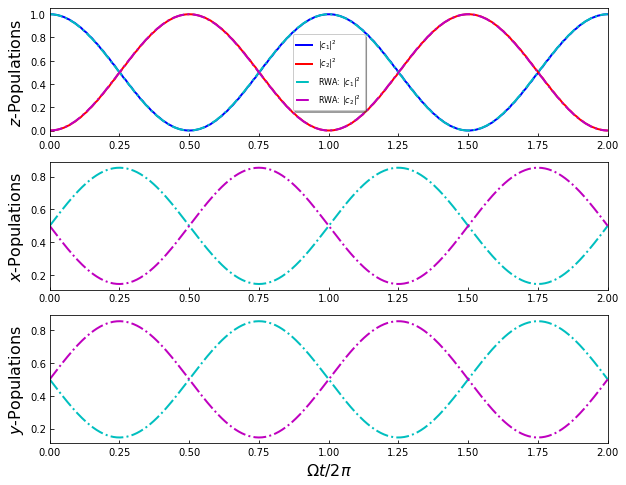

In [5]:
#----- Plot Reuslts -----
fig = plt.figure( figsize=(10,8) )
axb, axs, axc = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
fs = 16 #Label fontsize
labels = ['$|c_{1}|^2$', '$|c_{2}|^2$'] #Plot labels

#--- Draw Plots ---
#Bare spins
axb.plot( Psi.times*(Omega/2/np.pi), Psi.expect[0], 'b-', lw=2, label=labels[0]) 
axb.plot( Psi.times*(Omega/2/np.pi), Psi.expect[1], 'r-', lw=2, label=labels[1])
axb.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[0], 'c-.', lw=2, label='RWA: ' + labels[0]) 
axb.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[1], 'm-.', lw=2, label='RWA: ' + labels[1])

#x-spins
axs.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[2], 'c-.', lw=2, label='RWA: ' + labels[0]) 
axs.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[3], 'm-.', lw=2, label='RWA: ' + labels[1])

#y-spins
axc.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[4], 'c-.', lw=2, label='RWA: ' + labels[0]) 
axc.plot( Psi_rwa.times*(Omega/2/np.pi), Psi_rwa.expect[5], 'm-.', lw=2, label='RWA: ' + labels[1])

#--- Plot Settings ---
axb.set_ylabel('$z$-Populations', fontsize=fs)
axs.set_ylabel('$x$-Populations', fontsize=fs)
axc.set_ylabel('$y$-Populations', fontsize=fs)

axc.set_xlabel('$\Omega t/2\pi$', fontsize=fs) #Comman x-label
axb.legend(loc='best', fancybox=True, shadow=True, framealpha=1, fontsize=8)
for ax in axb, axs, axc:
    ax.set_xlim([0,periods]) #Remove extra spaces at ends
    ax.tick_params(direction='in') #Set grid-ticks inward
plt.show()

## Bloch Sphere Animations

Now we wish to take these results and plot them on the Bloch sphere for easy interpretation of the specific states as they change in time.

In [6]:
#----- RWA States -----
#--- Parameters ---
Omega = 1 #Rabi frequency
phi = np.pi/2 #Phase
delta = 0.15 #Field detuning

Hrwa = (delta/2)*sz + (Omega/2) * (np.sin(phi)*sx + np.cos(phi)*sy) #RW-Hamiltonian w/ phase
t = np.linspace(0, periods*(2*np.pi/Omega), num=50) #Time axis, fewer points

Psi_rwa = qt.sesolve(Hrwa, psi0, t) #Resolve for just the states
states = Psi_rwa.states #The resulting states

In [7]:
#----- Animation -----
#--- Remove Old Animation ---
import os

try:
    os.remove( 'Two-Level_BS.mp4' )
except OSError:
    pass #If the file doesn't exist it won't crash

#--- Begin New Plot ---
fig = plt.figure()
b = qt.Bloch() #Bloch sphere class

#--- Settings ---
b.view = [-40,30] #Viewing angle
b.vector_color = 'b'
b.point_color = 'b'
b.point_marker = 'o'
points = 20 #Number of points to show
point_sizes = [2*i for i in range(1,points+1)] #Change point size small -> big

#--- Draw Figure ---
b.add_states(states[0]) #Initial state
files = [] #List of created image files

for i,state in enumerate(states):
    b.clear() #Clear previous drawings
    b.add_states(state) #Add next state
    
    if i<points:
        b.point_size = point_sizes[:i+1] #Increase point size with each new point
        b.add_states(states[:i], 'point')
    else:
        b.add_states(states[i-points:i], 'point') #Only plot last few points
        
    b.save(dirc='tmp') #saving images to tmp directory in current working directory
    files.append( f'tmp/bloch_{i}.png' ) #Add new image to list

#--- Compile Images into .mp4 ---
import subprocess #For calling ffmpeg

#.mp4 then .gif
subprocess.call(['ffmpeg', '-r', '10', '-i', 'tmp/bloch_%01d.png', '-vf', 'format=yuv420p', 'Two-Level_BS.mp4'])
subprocess.call(['ffmpeg', '-r', '10', '-i', 'tmp/bloch_%01d.png', 'Two-Level_BS.gif'])

#--- Remove Raw Images ---
for file in files:
    try:
        os.remove( file ) #Delete images
    except OSError:
        pass #If the file doesn't exist it won't crash

<Figure size 432x288 with 0 Axes>